In [1]:
import glob
import re
import subprocess
import os
from datetime import datetime
from graphviz import Digraph

# Global Variables

In [2]:
STRACE_TIME_FORMAT = '%H:%M:%S.%f' #03:05:34.993967

In [3]:
###### regex #########
RE_PID = 'log.([0-9]*)' # strace.log.(1242).exec
RE_TIME = '^(.*?) ' # (04:31:48.580504) execve(...)
RE_EXECVE_COMMAND = '\", \[\"(.*?)\"' # "/bin/sed", ["(sed)", "-i", "-e", "/exit/d", "/etc/rc.local"], ["SHLVL=1", "_=/usr/bin/strace", "PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin", "LANG=C.UTF-8", "PWD=/"]
RE_EXECVE_OPTION = '\", \[\".*?\", (.*?)\],' # "/bin/sed", [("sed", "-i", "-e", "/exit/d", "/etc/rc.local")], ["SHLVL=1", "_=/usr/bin/strace", "PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin", "LANG=C.UTF-8", "PWD=/"]
RE_CONNECT_ADDR = '(.*?),.*family=(.*),.*htons\(([0-9]*)\).*addr\(\"(.*)\"' # 4, {sa_family=(AF_INET), sin_port=htons(25000), sin_addr=inet_addr("123.129.217.153")}, 16
RE_CONNECT_FAMILY = 'family=(.*?),'
RE_LOG_MERGE_CALL = '^.*? (.*)' # 1874  (06:57:05.321833 brk(0)                  = 0x5dc000)
RE_IOCTL_NAME = 'ifr_name="(.*?)"'
RE_SENDTO_ADDR = '^(.*?),.*htons\((.*?)\).*addr\(\"(.*)\"\)' # (-1), "E\0\0(\", 40, MSG_NOSIGNAL, {sa_family=AF_INET, sin_port=htons(23), sin_addr=inet_addr("159.79.135.69")}, 16

ENDPOINT_REGEX = '([0-9]+\.*){4}:[0-9]+'
PRIVATE_IP_REGEX = '(^127\.)|(^10\.)|(^172\.1[6-9]\.)|(^172\.2[0-9]\.)|(^172\.3[0-1]\.)|(^192\.168\.)'

In [4]:
###### Syscall Table ######
process_creation = ['clone', 'fork', 'vfork']
open_file = ['open', 'openat']
write_file = ['write', 'rename']
info = ['uname', 'sysinfo']
send = ['send', 'sendto', 'sendmsg']
recv = ['recv', 'recvfrom', 'recvmsg']
remove = ['unlink', 'unlinkat', 'rmdir']
link = ['symlink', 'symlinkat', 'link', 'linkat']

#### ignore path ####
ignore_paths = ['/dev/null', 'stdout', 'stderr']

# Trace Parser

In [5]:
def parse_line(log):
    signal = re.search('--- (SIG.*?) {(.*)}', log)
    term = re.search('[0-9]* \+\+\+ (.*) \+\+\+', log)
    
    info = {}
    
    if signal:
        info['type'] = 'sig'
        info['name'] = signal.group(1)
        info['args'] = signal.group(2)
    elif term:
        info['type'] = 'term'
        info['status'] = term.group(1)
    else: 
        info['type'] = 'sys'
        g = re.search(' (.*?)\((.*)\).*= (.*)', log)
        
        # uncompleted function caused by terminating execution
        if not g:
            return None
        
        info['name'] = g.group(1)
        info['args'] = g.group(2)
        info['return'] = g.group(3)
        info['success'] = True
        info['return_msg'] = None
        
        
        # return status: True for success, False for error (startswith E or ?)
        ret = info['return'].split(' ')
        if len(ret) > 1:
            info['return'] = ret[0]
            info['return_msg'] = ' '.join(ret[1:])
            
            # inspect first char of return description ()
            if ret[1].startswith('E'):
                info['success'] = False
                info['return_msg'] = ' '.join(ret[2:])
                
        if info['return'] == '?':
            info['success'] = False
    
    time = re.search(RE_TIME, log).group(1)
    info['time'] = time
    
    return info

In [6]:
# 修改
def strace_log_merge(path):
    f = open(f'{path}/merge.log', 'w')
#     p = subprocess.Popen(['strace-log-merge', f'{path}/strace.log'], stdout = f, bufsize=0)
#     p = subprocess.Popen(['strace-log-merge', f'{path}/T1049-AT3.sh.log'], stdout = f, bufsize=0) # For single process
    TECHLOG_ID = path.split("\\")[-1] + ".sh.log"
    p = subprocess.Popen(['strace-log-merge', f'{path}/{TECHLOG_ID}'], stdout = f, bufsize=0)

    out, err = p.communicate()
    f.close()
    if err:
        return False
    
    return True

In [7]:
def myprint(syscall, name):
    if syscall['name'] == name:
        print(f"{syscall['args']}: {syscall['return']}")

In [8]:
class Node:
    def __init__(self, name, typ='p'):
        self.name = name
        self.type = typ
        self.technique = ''
        self.tactic = ''
        self.color = None
        self.id = None
class Edge:
    def __init__(self, name, timestamp):
        self.name = name
        self.timestamp = timestamp
        self.technique = ''
        self.tactic = ''
        self.color = None
        self.id = None

# File Descriptor Handler

In [9]:
class FileTable:
    def __init__(self):
        self.fd_table = {
            '0': 'stdin',
            '1': 'stdout',
            '2': 'stderr'
        }
    
    def is_used(self, fd):
        return fd in self.fd_table
    
    def add(self, fd, path = None):
        self.fd_table[fd] = path
        
    def rm(self, fd):
        if self.is_used(fd):
            return self.fd_table.pop(fd)
        else:
            return False
        
    def get(self, fd):
        if self.is_used(fd):
            return self.fd_table[fd]
        else:
            return False
        
    def update(self, fd, path):
        if self.is_used(fd):
            self.fd_table[fd] = path
            return True
        else:
            return False
        
    def __str__(self):
        display = '-----------\n'
        for fd, path in self.fd_table.items():
            display += f'{fd}: {path}\n'
        display += '-------------\n'
        return display

# System Call Parser

In [10]:
class SyscallParser:
    def __init__(self):        
        self.parse_handler = {
            'execve': self.execve,
            'open': self.openn,
            'openat': self.openat,
            'read': self.read,
            'close': self.close,
            'write': self.write,
            'rename': self.rename,
            'socket': self.socket,
            'connect': self.connect,
            'send': self.send,
            'sendto': self.sendto,
            'sendmsg': self.sendmsg,
            'recv': self.recv,
            'recvfrom': self.recvfrom,
            'recvmsg': self.recvmsg,
            'ioctl': self.ioctl,
            'unlink': self.unlink,
            'unlinkat': self.unlinkat,
            'rmdir': self.rmdir,
            'bind': self.bind,
            'mkdir': self.mkdir,
            'symlink': self.symlink,
            'symlinkat': self.symlinkat,
            'link': self.link,
            'linkat': self.linkat,
            'kill': self.kill,
            'ptrace': self.ptrace
        }
        
    def execve(self):
        info = {}
        
        command = re.search(RE_EXECVE_COMMAND, self.syscall['args'])
        if command:
            command = command.group(1)
        else:
            command = re.search('\"(.*)\"', self.syscall['args'].split(',')[0]).group(1)
            
        option = re.search(RE_EXECVE_OPTION, self.syscall['args'])
        
        # if execve command has option: return option, else option = None
        if option:
            option = option.group(1)
            
        info['command'] = command
        info['option'] = option
        
        return info
    
    def openn(self):
        info = {}
        args = re.search('\"(.*)\", (.*)', self.syscall['args'])
        
        if not args:
            return False
        
        path = args.group(1)
        mode = args.group(2)
        
        info['path'] = path
        info['mode'] = mode
        
        return info
    
    def openat(self):
        info = {}
        args = re.search('\"(.*)\", (.*)', self.syscall['args'])
        
        if not args:
            return False
        
        path = args.group(1)
        mode = args.group(2)
        
        info['path'] = path
        info['mode'] = mode
        
        return info
    
    def close(self):
        info = {}
        info['fd'] = self.syscall['args']
        
        return info
    
    def write(self):
        info = {}
        info['fd'] = self.syscall['args'].split(',')[0]
        return info
    
    def rename(self):
        info = {}
        args = self.syscall['args'].split(',')
        info['path'] = re.search('\"(.*)\"', args[1]).group(1)
        
        return info
    
    def read(self):
        info = {}
        info['fd'] = self.syscall['args'].split(',')[0]
        return info
    
    def socket(self):
        info = {}
        info['fd'] = self.syscall['return']
        
        data = self.syscall['args'].split(',')
        info['family'] = data[0].strip()
        
        proto = data[1].strip()
        if proto == 'SOCK_STREAM':
            info['proto'] = 'TCP'
        elif proto == 'SOCK_DGRAM':
            info['proto'] = 'UDP'
        else:
            info['proto'] = proto
        
        return info
    
    def bind(self):
        info = {}
        family = re.search(RE_CONNECT_FAMILY, self.syscall['args']).group(1)
        if family not in ['AF_INET', 'PF_INET']:
            info['family'] = family
            return info
        
        conn = re.search(RE_CONNECT_ADDR, self.syscall['args'])
        
        info['fd'] = conn.group(1)
        info['family'] = conn.group(2)
        info['addr'] = conn.group(4) + ':' + conn.group(3)
        
        return info
    
    def connect(self):
        info = {}
        family = re.search(RE_CONNECT_FAMILY, self.syscall['args']).group(1)
        if family not in ['AF_INET', 'PF_INET']:
            info['family'] = family
            return info
        
        conn = re.search(RE_CONNECT_ADDR, self.syscall['args'])
        
        info['fd'] = conn.group(1)
        info['family'] = conn.group(2)
        info['addr'] = conn.group(4) + ':' + conn.group(3)
        
        return info
    
    def send(self):
        info = {}
        info['fd'] = self.syscall['args'].split(',')[0].strip()
        
        return info
    
    def sendto(self):
        # sendto(int sockfd, const void *buf, size_t len, int flags,
        #const struct sockaddr *dest_addr, socklen_t addrlen);
        info = {}
        send = re.search(RE_SENDTO_ADDR, self.syscall['args'])
        
        # sendto that have no addr info like AF_UNIX or dest_addr = NULL
        if not send:
            info['fd'] = self.syscall['args'].split(',')[0].strip()
            return info
        
        info['fd'] = send.group(1)
        info['addr'] = send.group(3) + ':' + send.group(2)
        
        return info
    
    def sendmsg(self):
        info = {}
        info['fd'] = self.syscall['args'].split(',')[0].strip()
        
        return info
    
    def recv(self):
        info = {}
        info['fd'] = self.syscall['args'].split(',')[0].strip()
        
        return info
    
    def recvfrom(self):
        info = {}
        recv = re.search(RE_SENDTO_ADDR, self.syscall['args'])
        
        # recvfrom that have no addr info like AF_UNIX or dest_addr = NULL
        if not recv:
            info['fd'] = self.syscall['args'].split(',')[0].strip()
            return info
        
        info['fd'] = recv.group(1)
        info['addr'] = recv.group(3) + ':' + recv.group(2)
        
        return info
    
    def recvmsg(self):
        info = {}
        info['fd'] = self.syscall['args'].split(',')[0].strip()
        
        return info
    
    def ioctl(self):
        info = {}
        #ioctl(0, SIOCGIFADDR, {ifr_name="eth0", ifr_addr={AF_INET, inet_addr("10.0.2.15")}})
        data = self.syscall['args'].split(',')
        info['fd'] = data[0].strip()
        info['req'] = data[1].strip()
        
        if info['req'] == 'SIOCGIFADDR':
            info['dev'] = re.search(RE_IOCTL_NAME, self.syscall['args']).group(1)
            
        return info
    
    def unlink(self):
        info = {}
        info['path'] = re.search('\"(.*)\"', self.syscall['args']).group(1)
        
        return info
    
    def unlinkat(self):
        info = {}
        info['path'] = re.search('\"(.*)\"', self.syscall['args'].split(',')[1]).group(1)
        
        return info
    
    def symlink(self):
        # int symlink(const char *target, const char *linkpath);
        info = {}
        t, l = self.syscall['args'].split(',')
        info['target'] = re.search('\"(.*)\"', t).group(1)
        info['link'] = re.search('\"(.*)\"', l).group(1)
        
        return info
        
    def symlinkat(self):
        # int symlinkat(const char *target, int newdirfd, const char *linkpath);
        info = {}
        t, f, l = self.syscall['args'].split(',')
        info['target'] = re.search('\"(.*)\"', t).group(1)
        info['link'] = re.search('\"(.*)\"', l).group(1)
        
        return info
    
    def link(self):
        # int link(const char *oldpath, const char *newpath);
        info = {}
        t, l = self.syscall['args'].split(',')
        info['target'] = re.search('\"(.*)\"', t).group(1)
        info['link'] = re.search('\"(.*)\"', l).group(1)
        
        return info
    
    def linkat(self):
        # int linkat(int olddirfd, const char *oldpath, int newdirfd, const char *newpath, int flags);
        info = {}
        d = self.syscall['args'].split(',')
        info['target'] = re.search('\"(.*)\"', d[1]).group(1)
        info['link'] = re.search('\"(.*)\"', d[3]).group(1)
        
        return info
    
    def rmdir(self):
        # int rmdir(const char *pathname);
        info = {}
        info['path'] = re.search('\"(.*)\"', self.syscall['args']).group(1)
        
        return info
    
    def mkdir(self):
        # int mkdir(const char *pathname, mode_t mode); 
        info = {}
        info['path'] = re.search('\"(.*)\"', self.syscall['args'].split(',')[0]).group(1)
        
        return info
    
    def kill(self):
        #int kill(pid_t pid, int sig);
        info = {}
        info['pid'] = self.syscall['args'].split(',')[0]
        
        return info
    
    def ptrace(self):
        info = {}
        args = self.syscall['args'].split(',')
        info['req'] = args[0]
        
        if len(args) >= 2:
            info['pid'] = args[1].strip()
        
        return info
        
    def parse(self, syscall): # syscall is a dict returned by parse_line()
        self.syscall = syscall
        self.name = syscall['name']
        
        return self.parse_handler[self.name]()
    
    
sys_parser = SyscallParser()

# Attack Scenario Graph Main Class Definition

In [27]:
# Ex: path = './root_real_network/Backdoor/Dofloo/fb3cf2464f43906cb96523752d74e5ad8e4eccf8ab74890e51fe24266921ef1c'
class AttackGraph:
    def __init__(self, path):
        self.malware_hash = path.split('/')[-1]
#         self.traces = sorted(glob.glob(path + '/strace*'))
        self.traces = sorted(glob.glob(path + '/*log.*'))
        self.graph = {}
        self.edges = {}
        
        self.proc_node_map = {}
        self.file_table = FileTable()
        
        # record seen file path
        self._file_node_map = {}
        
        # unique ip set
        self.unique_ip = set()
        
        # handler function
        self._syscall_handler_table = {
            'process': self._process,
            'read': self._read,
            'open': self._openn,
            'execve': self._execve,
            'close': self._close,
            'write': self._write,
            'socket': self._socket,
            'connect': self._connect,
            'info': self._info,
            'send': self._send,
            'recv': self._recv,
            'ioctl': self._ioctl,
            'rm': self._rm,
            'bind': self._bind,
            'mkdir': self._mkdir,
            'link': self._link,
            'kill': self._kill,
            'ptrace': self._ptrace
        }
        
        self._path = path
        
    def replace_cwd(self, node):
        cwd = '/prober/host_share/'
        if node.name.split('/')[-1] == self.malware_hash:
            node.name = 'malware'
    
        if node.name.startswith(cwd):
            node.name = './' + node.name.replace(cwd, '')
    
    # connect two nodes
    def _connect_node(self, from_node, to_node, edge):
        #if to_node.name == 'sysinfo':
        #    print(f'Connect {from_node.name} to {to_node.name}')
        self.replace_cwd(from_node)
        self.replace_cwd(to_node)
        
        self.graph[from_node].append(to_node)
        self.edges[(from_node, to_node, edge.name)] = edge
    
    # connect proc to file if there is no edge between them currently
    # from_proc: edge direction
    # if True: current node to file node (write, exec...). False: file node to current node (read)
    def _connect_proc_file(self, path, edge_name, time, from_proc = True, node_typ = 'f'):
        
        # if file node not exist: create new node, else: connect current node to exist file node
        if path not in self._file_node_map and path not in self.proc_node_map:
            child_node = Node(path, node_typ)
            
            if from_proc:
                from_node = self.current_node
                to_node = child_node
            else:
                from_node = child_node
                to_node = self.current_node
            
            if node_typ != 'p':
                self._file_node_map[path] = child_node
            else:
                self.proc_node_map[path] = child_node
            
            self.graph[child_node] = []
            self._connect_node(from_node, to_node, Edge(edge_name, time)) 
        # file node exist
        else:
            if node_typ != 'p':
                child_node = self._file_node_map[path]
            else:
                child_node = self.proc_node_map[path]
                
            if from_proc:
                from_node = self.current_node
                to_node = child_node
            else:
                from_node = child_node
                to_node = self.current_node
                
            # if curent node has not connected to file node (escape loop in strace.log)
            if (from_node, to_node, edge_name) not in self.edges:
                self._connect_node(from_node, to_node, Edge(edge_name, time))
    
    # remove connection between two nodes
    def _rm_connect(self, edge):
        from_node, to_node, _ = edge
        self.graph[from_node].remove(to_node)
        self.edges.pop(edge)
        
    def _find_path_by_fd(self, fd, time):
        path = 'Unknown'
        local_file_table = FileTable()
        
        # malware use only one ip
        if len(self.unique_ip) == 1:
            path = list(self.unique_ip)[0]
        
        # rebuild fd table from first line of merge.log
        else:
            if not os.path.isfile(f'{self._path}/merge.log'):
                strace_log_merge(self._path)

            with open(f'{self._path}/merge.log', 'r') as f:
                for line in f:
                    try:
                        line2 = re.search(RE_LOG_MERGE_CALL, line).group(1)
                    except AttributeError:
                        print(line)
                        raise
                    syscall = parse_line(line2)

                    if not syscall or syscall['type'] != 'sys':
                        continue

                    name = syscall['name']

                    # if found: get path and update class file_table
                    if syscall['time'] == time:
                        path = local_file_table.get(fd)
                        if not path:
                            pass
                            #print(syscall)
                            #raise KeyError('_find_path_by_fd: fd not found.')
                        self.file_table.update(fd, path)
                        break

                    # build fd table
                    if syscall['success']:
                        if name in open_file:
                            info = sys_parser.parse(syscall)
                            local_file_table.add(syscall['return'], info['path'])
                        elif name == 'socket':
                            info = sys_parser.parse(syscall)
                            # update fd table if create socket successfully
                            if info['family'] not in ['AF_INET', 'PF_INET']: ### PE_INET ???
                                local_file_table.add(fd, info['family'])
                            else:
                                local_file_table.add(syscall['return'])

                        elif name == 'close':
                            info = sys_parser.parse(syscall)
                            local_file_table.rm(info['fd'])
                            
                        elif name == 'connect': # 縮排錯誤?
                            info = sys_parser.parse(syscall)
                            # ignore IPC usage
                            if info['family'] not in ['AF_INET', 'PF_INET']:
                                return
                            local_file_table.update(info['fd'], info['addr'])
        
        return path
        
    def _process(self, syscall):
        pid = syscall['return']
        child_node = Node(pid)
        self.proc_node_map[pid] = child_node
        self.graph[child_node] = []

        if self._inside_execve:
            edge = Edge('exec', syscall['time'])
        else:
            edge = Edge(syscall['name'], syscall['time'])

        self._connect_node(self.current_node, child_node, edge)
    
    def _execve(self, syscall):
        self._inside_execve = True
            
        info = sys_parser.parse(syscall)
        if info['command'].split('/')[-1] == self.malware_hash:
            info['command'] = 'malware'

        # set current ndoe name = execve command
        self.current_node.name = info['command']

        # find target file if command has option
        if info['option']:
            self._execve_options = [ re.search('\"(.*)\"', opt).group(1) for opt in info['option'].split(',')]
        else:
            self._execve_options = []
            
    def _read(self, syscall):
        info = sys_parser.parse(syscall)
        fd = info['fd']
        path = self.file_table.get(fd)
        
        # fd may open in parent process
        if not path and not self._inside_execve:
            path = self._find_path_by_fd(fd, syscall['time'])
            
        # ignore paths
        if path in ignore_paths:
            return
        
        edge_name = 'read'
#         if not syscall['success']:
#             edge_name = f"read{syscall['return_msg']}"
        
        # if fd exist in fd table 
        if path:
            # if file appear in execve or currently not in execve
            # 是由 execve 觸發的 path 就要在 execve_options中；或者不是由 execve 觸發
            if (self._inside_execve and (path in self._execve_options)) or not self._inside_execve:
                # file node not exist
                if path not in self._file_node_map:
                    child_node = Node(path, typ='f')
                    self._file_node_map[path] = child_node
                    self.graph[child_node] = []
                    self._connect_node(child_node, self.current_node, Edge(edge_name, syscall['time']))

                # file node exist
                else:
                    child_node = self._file_node_map[path]
                    # if curent node has connected to file node open(), remove open edge
                    replace_edge_name = ['open', 'connect']
                    for exist_edge_name in replace_edge_name:
                        edge = (self.current_node, child_node, exist_edge_name)
                        if edge in self.edges:
                            self._rm_connect(edge)

                    # if has conected with read(), don't re-connect current node and child node
                    if (child_node ,self.current_node, edge_name) not in self.edges:
                        self._connect_node(child_node, self.current_node, Edge(edge_name, syscall['time']))
                    
            
    def _write(self, syscall):
        info = sys_parser.parse(syscall)
        if 'fd' in info:
            fd = info['fd']
            path = self.file_table.get(fd)
        else:
            path = info['path']
        
        # fd may open in parent process
        if not path and not self._inside_execve:
            path = self._find_path_by_fd(fd, syscall['time'])
        
        # ignore paths
        if path in ignore_paths:
            return
            
        edge_name = 'write'
#         if not syscall['success']:
#             edge_name = f"write{syscall['return_msg']}"
        
        # if fd exist in fd table 
        if path:
            # if file appear in execve or currently not in execve
            if (self._inside_execve and (path in self._execve_options)) or not self._inside_execve:
                # file node not exist
                if path not in self._file_node_map:
                    child_node = Node(path, typ='f')
                    self._file_node_map[path] = child_node
                    self.graph[child_node] = []
                    self._connect_node(self.current_node, child_node, Edge(edge_name, syscall['time']))

                # file node exist
                else:
                    child_node = self._file_node_map[path]
                    
                    # if curent node has connected to file node open(), remove open and connect edge
                    replace_edge_name = ['open', 'connect']
                    for exist_edge_name in replace_edge_name:
                        edge = (self.current_node, child_node, exist_edge_name)
                        if edge in self.edges:
                            self._rm_connect(edge)
                    
                    # if has conected with write(), don't re-connect current node and child node
                    if (self.current_node, child_node, edge_name) not in self.edges:
                        self._connect_node(self.current_node, child_node, Edge(edge_name, syscall['time']))
        
           
    def _openn(self, syscall):
        info = sys_parser.parse(syscall)
        if not info:
            return
        path = info['path']
        
        edge_name = 'open'
#         if not syscall['success']:
#             edge_name = f"open{syscall['return_msg']}"

        # update fd table if open successfully
        if syscall['success']:
            self.file_table.add(syscall['return'], info['path'])
            #print(f"open {info['path']}: {self.file_table}")
        
        if path in ignore_paths:
            return
        
        # open and openat appear after execve in same strace.log
        if self._inside_execve:
            # find path that apeears in execve command option
            #print(path, self._execve_options, self._execve_options[0])
            if path in self._execve_options:
                self._connect_proc_file(path, edge_name, syscall['time']) 

        # not inside execve
        else:
            self._connect_proc_file(path, edge_name, syscall['time'])
        
    def _close(self, syscall):
        info = sys_parser.parse(syscall)
        fd = info['fd']
        
        # delete fd only if successfully close
        if syscall['success']:
            self.file_table.rm(fd)
        
    def _info(self, syscall):
        edge_name = 'read'
        path = syscall['name']
        
        if not self._inside_execve:
            self._connect_proc_file(path, edge_name, syscall['time'], from_proc = False, node_typ = 'c')

        
    def _socket(self, syscall):
        info = sys_parser.parse(syscall)
        fd = info['fd']
        
        if not syscall['success']:
            return
        
        # update fd table if create socket successfully
        if info['family'] not in ['AF_INET', 'PF_INET']:
            self.file_table.add(fd, "NOT_NET")
        else:
            self.file_table.add(syscall['return'])
        #print('socket: ', self.file_table)
        
    def _bind(self, syscall):
        info = sys_parser.parse(syscall)
        
        # ignore IPC usage
        if info['family'] not in ['AF_INET', 'PF_INET']:
            return
        
        fd = info['fd']
        path = info['addr']
        edge_name = 'bind'
        
        res = self.file_table.update(fd, path)
        if not res:
            print('socket fd not found.')
            raise KeyError
            
        self._connect_proc_file(path, edge_name, syscall['time'], node_typ = 'n')
        
    def _connect(self, syscall):
        info = sys_parser.parse(syscall)
        
        # ignore IPC usage
        if info['family'] not in ['AF_INET', 'PF_INET']:
            return
        
        fd = info['fd']
        path = info['addr']
        self.unique_ip.add(path)
        edge_name = 'connect'
        
        res = self.file_table.update(fd, path)
        if not res:
            print('socket fd not found.')
            raise KeyError
        
        # if file node not exist: create new node, else: connect current node to exist file node
        self._connect_proc_file(path, edge_name, syscall['time'], node_typ = 'n')
    
    def _recv(self, syscall):
        info = sys_parser.parse(syscall)
        fd = info['fd']
        edge_name = 'recv'
        
        # socket error
        if fd == '-1':
            # get ip addr from recvfrom
            if syscall['name'] == 'recvfrom':
                if 'addr' in info:
                    path = info['addr']
                    self.unique_ip.add(path)
                elif len(self.unique_ip) == 1:
                    path = list(self.unique_ip)[0]
                else:
                    return
                    
            else:
                return
            
        # socket create successfully
        if fd != '-1':
            # AF_UNIX socket
            if self.file_table.get(fd) == "NOT_NET":
                return
            
            # if malware use UDP, we need to map fd to ip addr through sendto
            if syscall['name'] == 'recvfrom' and not self.file_table.get(fd):
                if 'addr' in info:
                    path = info['addr']

                elif len(self.unique_ip) == 1:
                    path = list(self.unique_ip)[0]

                self.file_table.update(fd, path)
                self.unique_ip.add(path)       
                
            path = self.file_table.get(fd)
            # created in parent process, find it
            if not path:
                path = self._find_path_by_fd(fd, syscall['time'])
        
        # file node not exist
        if path not in self._file_node_map:
            child_node = Node(path, typ='n')
            self._file_node_map[path] = child_node
            self.graph[child_node] = []
            self._connect_node(child_node, self.current_node, Edge(edge_name, syscall['time']))

        # file node exist
        else:
            child_node = self._file_node_map[path]
            # if curent node has connected to file node open(), remove open edge
            replace_edge_name = ['connect']
            for exist_edge_name in replace_edge_name:
                edge = (self.current_node, child_node, exist_edge_name)
                if edge in self.edges:
                    self._rm_connect(edge)

            # if has conected with recv(), don't re-connect current node and child node
            if (child_node, self.current_node, edge_name) not in self.edges:
                self._connect_node(child_node, self.current_node, Edge(edge_name, syscall['time']))
        
    def _send(self, syscall):
        print("System Call:", syscall)
        info = sys_parser.parse(syscall)
        fd = info['fd']
        print("fd info:", info)
        edge_name = 'send'
        
        # socket create unsuccessfully
        if fd == '-1':
            if syscall['name'] == 'sendto':
                if 'addr' in info:
                    path = info['addr']
                    
                    self.unique_ip.add(path) 
                elif len(self.unique_ip) == 1:
                    path = list(self.unique_ip)[0]
                else:
                    return
                    
            else:
                return
            
        # socket create successfully
        if fd != '-1':
            # AF_UNIX socket
            if self.file_table.get(fd) == "NOT_NET":
                return
            
            # if malware use UDP, we need to map fd to ip addr through sendto
            if syscall['name'] == 'sendto' and not self.file_table.get(fd):
                if 'addr' in info:
                    path = info['addr']
                    print("if path:", path)

                elif len(self.unique_ip) == 1:
                    path = list(self.unique_ip)[0]
                    print("elif path:", path)
                
                print("info:", info)
                print("Out path:", path)
                self.file_table.update(fd, path)
                self.unique_ip.add(path)       
                
            path = self.file_table.get(fd)
            # created in parent process, find it
            if not path:
                path = self._find_path_by_fd(fd, syscall['time'])
        
            
        # file node not exist
        if path not in self._file_node_map:
            child_node = Node(path, typ='n')
            self._file_node_map[path] = child_node
            self.graph[child_node] = []
            self._connect_node(self.current_node, child_node, Edge(edge_name, syscall['time']))

        # file node exist
        else:
            child_node = self._file_node_map[path]
            # if curent node has connected to file node open(), remove open edge
            replace_edge_name = ['connect']
            for exist_edge_name in replace_edge_name:
                edge = (self.current_node, child_node, exist_edge_name)
                if edge in self.edges:
                    self._rm_connect(edge)

            # if has conected with send(), don't re-connect current node and child node
            if (self.current_node, child_node, edge_name) not in self.edges:
                self._connect_node(self.current_node, child_node, Edge(edge_name, syscall['time']))
                
    def _ioctl(self, syscall):
        info = sys_parser.parse(syscall)
        if info['req'] != 'SIOCGIFADDR':
            return
        
        edge_name = 'read'
        path = info['dev']
        self._connect_proc_file(path, edge_name, syscall['time'], from_proc = False, node_typ = 'n')
        
    
    def _rm(self, syscall):
        info = sys_parser.parse(syscall)
        path = info['path']
        
        edge_name = 'rm'
        self._connect_proc_file(path, edge_name, syscall['time'])
        
    def _mkdir(self, syscall):
        info = sys_parser.parse(syscall)
        path = info['path']
        
        edge_name = 'mkdir'
        self._connect_proc_file(path, edge_name, syscall['time'])
        
    def _link(self, syscall):
        info = sys_parser.parse(syscall)
        t = info['target']
        l = info['link']
        
        self._connect_proc_file(t, 'read', syscall['time'], from_proc = False)
        self._connect_proc_file(l, 'write', syscall['time'])
        
    
    def _kill(self, syscall):
        info = sys_parser.parse(syscall)
        pid = info['pid']
        
        self._connect_proc_file(pid, 'kill', syscall['time'], node_typ = 'p')
        
    def _ptrace(self, syscall):
        info = sys_parser.parse(syscall)
        req = info['req'].lower()
        if 'pid' in info:
            self._connect_proc_file(info['pid'], req, syscall['time'], node_typ = 'p')
        else:
            self._connect_proc_file(self.current_node.name, req, syscall['time'], node_typ = 'p')
        
    def _syscall_handler(self, syscall):
        name = syscall['name']
        
        # child process creation
        if name in process_creation:
            self._syscall_handler_table['process'](syscall) # 用 self._syscall_handler_table['process'] = self._process() 處理 System Call
        
        # file open
        elif name in open_file:
            self._syscall_handler_table['open'](syscall)
            
        elif name in write_file:
            self._syscall_handler_table['write'](syscall)
        
        elif name in info:
            self._syscall_handler_table['info'](syscall)
            
        elif name in send:
            self._syscall_handler_table['send'](syscall)
        
        elif name in recv:
            self._syscall_handler_table['recv'](syscall)
            
        elif name in remove:
            self._syscall_handler_table['rm'](syscall)
            
        elif name in link:
            self._syscall_handler_table['link'](syscall)
        
        elif name in self._syscall_handler_table: # 只有這一行就可以完成上面所有的事情，但不能排優先順序?
            self._syscall_handler_table[name](syscall)
    
    # main method to create attck graph
    def create(self):
        for idx, trace in enumerate(self.traces):
            #print(trace)
            proc_id = re.search(RE_PID, trace).group(1)
            # init root node
            if idx == 0:
                self.proc_node_map[proc_id] = Node('malware')
            
            # current process node for this trace
            self.current_node = self.proc_node_map[proc_id]
            self.graph[self.current_node] = []
            self._inside_execve = False
            
            first_line = True
            with open(trace, 'r') as f:
                for line in f:
                    if idx == 0 and first_line:
                        first_line = False
                        continue
                    line = line.strip()
                    call = parse_line(line) # Trace Log Parser
                    
                    if not call:
                        continue

                    if call['type'] == 'sys':
                        self._syscall_handler(call)
                         #myprint(call, 'socket')

    def sort_edges(self, edges, rm_nodes):
        if len(rm_nodes) != 0:
            edges = [edge for pair, edge in edges.items() if pair[0] not in rm_nodes and pair[1] not in rm_nodes]
        else:
            edges = list(edges.values())
            
        edges.sort(key = lambda edge: datetime.strptime(edge.timestamp, STRACE_TIME_FORMAT))
        self._edges_sort_map = {}
        
        for idx, edge in enumerate(edges):
            self._edges_sort_map[edge] = str(idx + 1)
            
    def node_reduction(self, depth):
        file_counter = {}
        ip_counter = {"External_IP": 0, "Local_IP": 0}
        
        file_set = set()
        ip_set = set()
        
        pub_ip_node = Node('External_IP', typ = 'n')
        pub_ip_node.color = COMMAND_CONTROL_COLOR
        pub_ip_node.tactic ='Command & Control', 
        pub_ip_node.technique = "Command & Control"
        pub_ip_node.id = "C&C"
        
        pri_ip_node = Node('Local_IP', typ = 'n')
    
        reduced_file_map = {}
        nodes = set()
        
        # create another edges for visualization
        node_pairs = []
        edge_vals = []
        for pair, edge in self.edges.items():
            node_pairs.append(pair)
            edge_vals.append(edge)
            
        edges = {}
        for pair_idx, pair in enumerate(node_pairs):
            new_pair = list(pair)
            for idx, node in enumerate(new_pair[:2]):
                # if node is a file or ip addr
                if node.type in ['f', 'n']:
                    if node.name.startswith('8.8.8.8'):
                        nodes.add(node)
                        continue
                        
                    if re.search(ENDPOINT_REGEX, node.name):
                        if re.search(PRIVATE_IP_REGEX, node.name):
                            if node.name not in ip_set:
                                ip_counter['Local_IP'] += 1
                                ip_set.add(node.name)
                                
                            new_pair[idx] = pri_ip_node
                            nodes.add(pri_ip_node)
                        else:
                            if node.name not in ip_set:
                                ip_counter['External_IP'] += 1
                                ip_set.add(node.name)
                                
                            new_pair[idx] = pub_ip_node
                            nodes.add(pub_ip_node)

                    # file path
                    else:
                        paths = node.name.split('/')
                        
                        if len(paths) <= depth:
                            name = "/".join(paths)
                        else:
                            name = "/".join(paths[:depth + 1])
                            

                        if name not in reduced_file_map:
                            file_node = Node(name, typ = 'f')
                            file_node.tactic = node.tactic
                            file_node.technique = node.technique
                            file_node.color = node.color
                            file_node.id = node.id
                            
                            reduced_file_map[name] = file_node
                            file_counter[name] = 1
                            file_set.add(node.name)
                            
                        else:
                            file_node = reduced_file_map[name]
                            
                            if node.name not in file_set:
                                file_set.add(node.name)
                                file_counter[name] += 1
                            
                        nodes.add(file_node)
                        new_pair[idx] = file_node
                        
                    
                # if node is process or command       
                else:
                    nodes.add(node)
                    
            # save new pair
            new_pair = tuple(new_pair)
            edges[new_pair] = edge_vals[pair_idx]
            
        # label count number on reduction node
        for node in nodes:
            if node.type == 'n' and node.name in ip_counter:
                count = ip_counter[node.name]
                if count > 1:
                    node.name = node.name + f" ({count})"
            elif node.type == 'f' and node.name in file_counter:
                count = file_counter[node.name]
                if count > 1:
                    node.name = node.name + f" ({count})"
                
            
        return nodes, edges
    
    def is_process_node(self, node):
        return node.type == 'p' and re.search('^[0-9]*$', node.name)
                                  
    def draw(self, showall = True, depth = 3):
        # Create Digraph object
        display_threshold = 30
        # twopi
        dot = Digraph(engine='dot', format='pdf')
        #dot.attr(size='35,50')
        #dot.graph_attr['overlap'] =  "false"
        #dot.graph_attr['splines'] = "true"
        
        node_table = {}
        nodes = list(self.graph.keys())
        edges = dict(self.edges)
        
        self.all_nodes_num = len(nodes)
        print('Node before reduction: ', self.all_nodes_num)
        self.color_nodes_num = 0
        
        
        # nodes to be removed
        rm_nodes = set()
        
        # remove node that have only on edge clone from parent
        if not showall:
            # node have no child node
            for node in nodes:
                # if a node have no child node
                if self.is_process_node(node):
                    if len(self.graph[node]) == 0:
                        rm_nodes.add(node)
                    
            for node in nodes:
                if len(self.graph[node]) == 1 and self.graph[node][0] in rm_nodes:
                    rm_nodes.add(node)

            # node in rm_nodes that have only one parent node which its edge in process_creation
            for pair, edge in edges.items():
                from_node, to_node, _ = pair
                if to_node in rm_nodes and edge.name not in process_creation:
                    rm_nodes.remove(to_node)
            
            for node in rm_nodes:
                print(f'Remove Node: {node.name}')
        
        print(self.all_nodes_num - len(rm_nodes))
        if (self.all_nodes_num - len(rm_nodes)) > display_threshold and not showall:
            nodes, edges = self.node_reduction(depth)
            
        
        # visulization node counting
        self.viz_nodes_num = len(nodes) - len(rm_nodes)
        print('Nodes after reduction: ', self.viz_nodes_num)
        # sort edge
        self.sort_edges(edges, rm_nodes)
        
        # draw node
        for idx, node in enumerate(nodes):
            idx = str(idx)
            
            if not showall and node in rm_nodes:
                continue
            
            
            node_name = node.name
            if node.technique:
                 node_name += f'\n({node.id})'
            
            if node.color:
                self.color_nodes_num += 1
                
            if node.type in ['f', 'c']:
                dot.node(idx, node_name, shape='rectangle', color = node.color, style='filled')
            elif node.type == 'n':
                dot.node(idx, node_name, shape='diamond', color = node.color, style='filled')
            else:
                dot.node(idx, node_name, color = node.color, style='filled')
                
            node_table[node] = idx
        
        self.node_seq = []
        
        # draw edge
        for pair, edge in edges.items():
            from_node, to_node, _ = pair
            
            if not showall and (from_node in rm_nodes or to_node in rm_nodes):
                continue
            
            self.node_seq.append([self._edges_sort_map[edge], from_node, to_node, edge])
            
            from_node = node_table[from_node]
            to_node = node_table[to_node]
            
            edge_name = self._edges_sort_map[edge] + '. ' + edge.name
            dot.edge(from_node, to_node, edge_name, color = edge.color)
        
        # sort node sequence
        self.node_seq = sorted(self.node_seq, key=lambda x: int(x[0]))
        
        return dot

# MITRE Mapping Rules

In [12]:
DISCOVERY_COLOR = '#FDE74C'
PERSISTENCE_COLOR = '#9BC53D'
EXECUTION_COLOR = '#26C485'
COMMAND_CONTROL_COLOR = '#CC5A71'

DISCOVERY = [{
    "tactic": "Discovery",
    "technique": "System Information Discovery",
    "id": "T1082",
    "file_edges": ['open', 'read'],
    "command_edges": ['exec'],
    "commands": ['lspci', 'dmidecode', 'lscpu', 'lsmod', 'hostname'],
    "files": ['/etc/lsb-release', '/etc/redhat-release', '/etc/issue', 'sysinfo', 'uname', 
              '/proc/cpuinfo', '/proc/meminfo', '/proc/stat', '/proc/version', '/proc/sys/kernel/version', 
              '/proc/sys/kernel/ngroups_max', '/sys/'],
    "color": DISCOVERY_COLOR
    
}, {
    "tactic": "Discovery",
    "technique": "System Network Connection Discovery",
    "id": 'T1049',
    "file_edges": ['open', 'read', 'connect'],
    "command_edges": ['exec'],
    "commands": ['netstat', 'lsof', 'who', 'w'],
    "files": ['/proc/net/dev', '/proc/net/tcp', '/proc/net/route', '8\.8\.8\.8'],
    "color": DISCOVERY_COLOR
}, {
    "tactic": "Discovery",
    "technique": "System Network Configuration Discovery",
    "id": "T1016",
    "file_edges": ['open', 'read'],
    "command_edges": ['exec'],
    "commands": ['arp', 'ifconfig', 'ip'],
    "files": ['/proc/net/arp', '/proc/net/unix', '/etc/nsswitch.conf', '/etc/resolv.conf',
              '/etc/host', 'eth'],
    "color": DISCOVERY_COLOR
}]

PERSISTENCE = [{
    "tactic": "Persistence",
    "technique": "Local Job Scheduling",
    "id": "T1168",
    "file_edges": ['open', 'write'],
    "command_edges": ['exec', 'clone', 'fork', 'vfork'],
    "commands": ['crontab'],
    "files": ['/etc/rc', '/etc/init', '/etc/cron', '/var/spool/cron'],
    'color': PERSISTENCE_COLOR
}]

EXECUTION = [{
    "tactic": "Execution",
    "technique": "Command-Line Interface",
    "id": 'T1059',
    "file_edges": [],
    "command_edges": ['clone', 'exec', 'fork', 'vfork'],
    "commands": ['sh', 'bash', 'dash', 'rbash'],
    "files": [],
    "color": EXECUTION_COLOR
}]

COMMAND_CONTROL = [{
    "tactic": "Command & Control",
    "technique": "Command & Control",
    "id": "C&C",
    "file_edges": [],
    "command_edges": ['exec', 'clone', 'fork', 'vfork'],
    "commands": ['nc', 'wget', 'curl'],
    "files": [],
    "color": COMMAND_CONTROL_COLOR
}]

# Tactic & Technique Graph Generation

In [13]:
# Generation of TT Graph
class TTPLabeler:
    def __init__(self, attack_graph):
        self.graph = attack_graph
        
    def set_technique(self, node, edge, rule):
        #print(edge.name, node.name)
        node.technique = rule['technique']
        node.tactic = rule['tactic']
        node.color = rule['color']
        node.id = rule['id']
        
        edge.technique = rule['technique']
        edge.tactic = rule['tactic']
        edge.color = rule['color']
    
    def mapper(self, rules):
        for rule in rules:            
            # map files
            if self.edge.name in rule['file_edges']:
                for node in self.nodes:
                    if node.type in ['f', 'n', 'c']:                                
                        for file in rule['files']:
                            if re.search(file, node.name):
                                self.set_technique(node, self.edge, rule)
                                return
            
            
            # map commands
            if self.edge.name in rule['command_edges']:
                for node in self.nodes:
                    if node.type == 'p':
                        for command in rule['commands']:
                            if re.search(f'^{command}$', node.name):
                                self.set_technique(node, self.edge, rule)
                                return
                            
    
    def execution_mapper(self):
        self.mapper(EXECUTION)
        
    def discovery_mapper(self):
        self.mapper(DISCOVERY)
    
    def persistence_mapper(self):
        self.mapper(PERSISTENCE)
        
    def command_control_mapper(self):
        self.mapper(COMMAND_CONTROL)
        
        # label external ip connection
        for node in self.nodes:
            if node.type != 'n':
                continue
            if node.name.startswith('8.8.8.8'):
                continue
                
            if self.edge.name not in ['send', 'recv', 'connect', 'read', 'write']:
                continue
                
            if re.search(ENDPOINT_REGEX, node.name) and not re.search(PRIVATE_IP_REGEX, node.name):
                self.set_technique(node, self.edge, COMMAND_CONTROL[0])
    
    def fit(self):
        edges = self.graph.edges
        for nodes, edge in edges.items():
            #print(nodes[0].name, nodes[1].name)
            self.nodes = nodes[:2]
            self.edge = edge
            
            # map each tactic
            self.discovery_mapper()
            self.persistence_mapper()
            self.execution_mapper()
            self.command_control_mapper()

# Generation of AS Graph & TT Graph

path: 設為動態側錄系統產生的惡意程式 traces 的路徑

In [14]:
# path = './root_real_network/Backdoor/Dofloo/fb3cf2464f43906cb96523752d74e5ad8e4eccf8ab74890e51fe24266921ef1c'

In [16]:
TACTIC = '/Execution'
TECHNIQUE_ID = '/T1059-AT2'
path = './output' + TACTIC + TECHNIQUE_ID
print(path)

./output/Execution/T1059-AT2


In [28]:
# Create Attack Scenario Graph
graph = AttackGraph(path)
graph.create()

# Create TT Graph based on AS Graph
mapper = TTPLabeler(graph)
mapper.fit()

# Create Visualization Instance
g = graph.draw(True)

System Call: {'type': 'sys', 'name': 'sendto', 'args': '7, {{nlmsg_len=20, nlmsg_type=RTM_GETADDR, nlmsg_flags=NLM_F_REQUEST|NLM_F_DUMP, nlmsg_seq=1654671908, nlmsg_pid=0}, {ifa_family=AF_UNSPEC, ...}}, 20, 0, {sa_family=AF_NETLINK, nl_pid=0, nl_groups=00000000}, 12', 'return': '20', 'success': True, 'return_msg': None, 'time': '15:05:08.882634'}
fd info: {'fd': '7'}
System Call: {'type': 'sys', 'name': 'sendto', 'args': '6, "\\1", 1, MSG_NOSIGNAL, NULL, 0', 'return': '1', 'success': True, 'return_msg': None, 'time': '15:05:08.888870'}
fd info: {'fd': '6'}
info: {'fd': '6'}


UnboundLocalError: local variable 'path' referenced before assignment

In [25]:
# Store the image
g.render(TECHNIQUE_ID[1:], format="png", view=True)

'T1082-AT3.png'

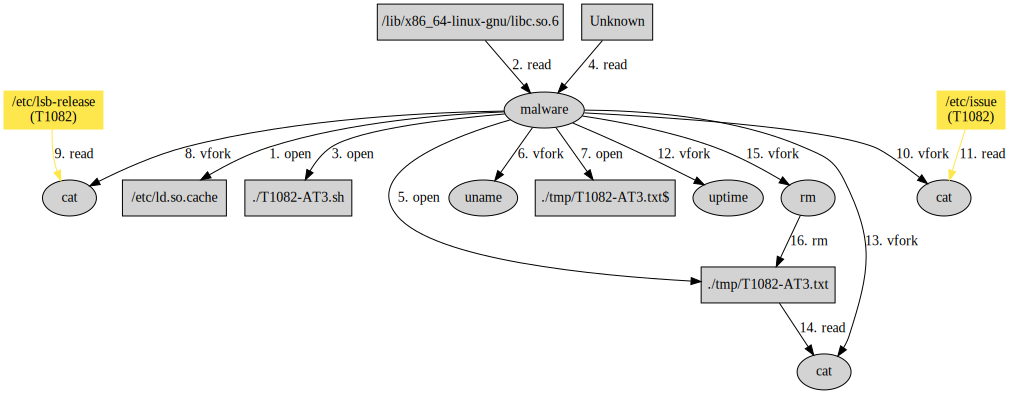

In [19]:
# Displat TT Graph
g

In [49]:
log_paths = glob.glob("./output/*/*")
print(log_paths[7])

./output\Execution\T1059.004-AT2


In [50]:
temp_path = log_paths[7]
# Create Attack Scenario Graph
graph = AttackGraph(temp_path)
graph.create()

# Create TT Graph based on AS Graph
mapper = TTPLabeler(graph)
mapper.fit()

# Create Visualization Instance
g = graph.draw(True)

# Store the image
TECHNIQUE_ID = temp_path.split("\\")[-1]
g.render(TECHNIQUE_ID, format="png", view=True)

UnboundLocalError: local variable 'path' referenced before assignment

In [52]:
## 一次畫出所有 trace log 的圖並存起來 ##
log_paths = glob.glob("./output/*/*")
print(log_paths)

for log_path in log_paths:
    
    # Create Attack Scenario Graph
    graph = AttackGraph(log_path)
    graph.create()

    # Create TT Graph based on AS Graph
    mapper = TTPLabeler(graph)
    mapper.fit()

    # Create Visualization Instance
    g = graph.draw(True)

    # Store the image
    TECHNIQUE_ID = path.split("\\")[-1]
    g.render(TECHNIQUE_ID, format="png", view=True)
    sleep(1) # 畫太快好像有時候會有Bug

['./output\\Command_and_Control\\T1571-AT2', './output\\Discovery\\T1049-AT3', './output\\Discovery\\T1082-AT11', './output\\Discovery\\T1082-AT3', './output\\Discovery\\T1082-AT4', './output\\Discovery\\T1082-AT5', './output\\Discovery\\T1082-AT7', './output\\Execution\\T1059.004-AT2']
Node before reduction:  8
8
Nodes after reduction:  8
Node before reduction:  1
1
Nodes after reduction:  1
Node before reduction:  14
14
Nodes after reduction:  14
Node before reduction:  15
15
Nodes after reduction:  15
Node before reduction:  38
38
Nodes after reduction:  38
Node before reduction:  29
29
Nodes after reduction:  29
Node before reduction:  14
14
Nodes after reduction:  14


UnboundLocalError: local variable 'path' referenced before assignment

# Tactics Time Sequence

In [17]:
for data in graph.node_seq:
    idx = data[0]
    from_node = data[1]
    to_node = data[2]
    edge = data[3]
    print(idx, edge.technique, '-', edge.tactic)

1 System Information Discovery - Discovery
2 Command-Line Interface - Execution
3 Command-Line Interface - Execution
4  - 
5 Local Job Scheduling - Persistence
6 Command-Line Interface - Execution
7 Command-Line Interface - Execution
8 Command-Line Interface - Execution
9 Command-Line Interface - Execution
10  - 
11 Local Job Scheduling - Persistence
12 Command-Line Interface - Execution
13 Command-Line Interface - Execution
14  - 
15 Local Job Scheduling - Persistence
16 Command-Line Interface - Execution
17 Command-Line Interface - Execution
18 Local Job Scheduling - Persistence
19 Command-Line Interface - Execution
20 Command-Line Interface - Execution
21 Local Job Scheduling - Persistence
22  - 
23  - 
24  - 
25 System Network Connection Discovery - Discovery
26 System Information Discovery - Discovery
27  - 
28 System Network Configuration Discovery - Discovery
29 System Information Discovery - Discovery
30 System Information Discovery - Discovery
31 System Information Discovery -

# Plot Graphs for Malware Family
批量產生各惡意家族下每隻惡意程式的 TT Graph，以 PDF 格式存

In [19]:
mode = 'root_real_network'
input_folder = f'./{mode}'
output_folder = f'./attack_graphs/{mode}'
malwares = glob.glob(input_folder+'/*/*/*')

In [20]:
# These two malwares generate too many traces that cuased system hang
special_cases = [
    '3848d8910c35d65335950f727434f741167f8072be0a8384caf53a30e507c46e',
    '84a1af5e8c87bf71172a58bca516e8e8929cabea2983f3941c161a97ec2e4d06'
]

In [23]:
big_graphs = []
nodes_status =[]
malware_files_set = set()

# save graph dot file source
def save_dot(dot, path, m_hash):
    os.makedirs(path, exist_ok=True)
    dot.render(f'{path}/{m_hash}')

# save files list that malware used
def save_files(files, path, m_hash):
    with open(f'{path}/{m_hash}.files.txt', 'w') as f:
        for file in files:
            f.write(f'{file}\n')

# generator
def graph_generator(malware_path):
    global malware_files_set, nodes_status, big_graphs
    m_typ, m_fam, m_hash = malware_path.split('/')[-3:]
    
    if m_hash in special_cases:
        return
        
    print('---', m_typ, m_fam, m_hash, '---')
    graph = AttackGraph(malware_path)
    graph.create()
    
    mapper = TTPLabeler(graph)
    mapper.fit()
    
    malware_files_set = malware_files_set.union(set(graph._file_node_map.keys()))
    dot = graph.draw(False, depth = 3)
    
    all_nodes_num = graph.all_nodes_num
    viz_nodes_num = graph.viz_nodes_num
    color_nodes_num = graph.color_nodes_num
    
    nodes_status.append([m_typ, m_fam, m_hash, all_nodes_num, viz_nodes_num, color_nodes_num])
    #return
    
    m_path = f'{output_folder}/{m_typ}/{m_fam}'
    save_dot(dot, m_path, m_hash)
    save_files(list(graph._file_node_map.keys()), m_path, m_hash)
    print('--- Done ---')

In [24]:
# Save graph PDF, dot source and file list for every malware
for m_path in malwares:
    graph_generator(m_path)

--- Exploit Small 6c3eeafd18595daa48bf903430a88750 ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- Exploit Small ebf56b867b18e322c0380c0c8432868b ---
Node before reduction:  4
4
Nodes after reduction:  4
--- Done ---
--- Exploit Small 480a064b302ec6341d8edfa03c184a40 ---
Node before reduction:  4
4
Nodes after reduction:  4
--- Done ---
--- Exploit Small 84d7377101664d072166bcb142b40f63 ---
Node before reduction:  3
3
Nodes after reduction:  3
--- Done ---
--- Exploit Small d923a5549548c5492516c5204d2f6889 ---
Node before reduction:  3
3
Nodes after reduction:  3
--- Done ---
--- Exploit Small 21eade6c9e4f4d3f4bb060fd0e2940dc ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- Exploit Small c7c873f5baad56d2889e0c819d73fae6 ---
Node before reduction:  3
3
Nodes after reduction:  3
--- Done ---
--- Exploit Small b88504fb961a3af44504804a77fb7547e4db3a55ebd49585947b720a3e99aa98 ---
Node before reduction:  1
1
Nodes after reduction:  1
--- D

Node before reduction:  28
Remove Node: 1905
Remove Node: 1906
26
Nodes after reduction:  26
--- Done ---
--- Backdoor Dofloo fa2212b1eb3ef6d349abf9957ca4e8869074f9a5c5cd987e46933f4fdb54c3f6 ---
Node before reduction:  36
Remove Node: 1458
Remove Node: /proc/net/dev
Remove Node: /sys/devices/system/cpu/online
Remove Node: 1457
Remove Node: /proc/stat
31
Nodes after reduction:  31
--- Done ---
--- Backdoor Dofloo 4a5d98f551781b4f3902e838998af3e641d54437a384381426ad9099f3348c97 ---
Node before reduction:  38
Remove Node: 1475
Remove Node: 1476
36
Nodes after reduction:  36
--- Done ---
--- Backdoor Dofloo ce05c038bc7226f538a9fb1f3ff5c9c074158bbcaead40b6bb6e01190dddd402 ---
Node before reduction:  25
25
Nodes after reduction:  25
--- Done ---
--- Backdoor Dofloo 9883752193bf865198a9997bb4067332cea9ffbc59b8f819307ab69bcf74fd7e ---
Node before reduction:  36
Remove Node: /proc/net/dev
Remove Node: 1325
Remove Node: /proc/stat
Remove Node: 1326
Remove Node: /sys/devices/system/cpu/online
31


Node before reduction:  73
Remove Node: 1534
Remove Node: 1507
Remove Node: 1511
Remove Node: 1487
Remove Node: 1531
Remove Node: 1528
Remove Node: 1510
Remove Node: 1513
Remove Node: 1489
Remove Node: 1535
Remove Node: 1533
Remove Node: 1512
Remove Node: 1515
Remove Node: 1491
Remove Node: 1492
Remove Node: 1536
Remove Node: 1514
Remove Node: 1517
Remove Node: 1496
Remove Node: 1516
Remove Node: 1519
Remove Node: 1498
Remove Node: 1493
Remove Node: 1518
Remove Node: 1509
Remove Node: 1501
Remove Node: 1521
Remove Node: 1497
Remove Node: 1520
Remove Node: 1523
Remove Node: 1503
Remove Node: 1499
Remove Node: 1488
Remove Node: 1485
Remove Node: 1522
Remove Node: 1506
Remove Node: 1526
Remove Node: 1502
Remove Node: 1525
Remove Node: 1505
Remove Node: 1529
32
Nodes after reduction:  32
--- Done ---
--- Backdoor Mayday d39e0a61576a797768f8a7dfb6dadb9a51643b9285b79a96eac296f38f567fc5 ---
Node before reduction:  73
Remove Node: 1390
Remove Node: 1380
Remove Node: 1353
Remove Node: 1376
Remo

Node before reduction:  17
17
Nodes after reduction:  17
--- Done ---
--- HEUR_Backdoor Dofloo 37a0d467147fc6190ae5872dad5f6de7b4f994f0e3d8f517e3d3630a77e1a320 ---
Node before reduction:  30
Remove Node: /proc/stat
Remove Node: /sys/devices/system/cpu/online
Remove Node: /proc/net/dev
Remove Node: 1855
26
Nodes after reduction:  26
--- Done ---
--- HEUR_Backdoor Dofloo b0eb520340ba035d05ec6b9b02078a385a1287ca02bd4020bc253af71ea633cc ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Dofloo 5a3590264394a769f16fde75e7fb7b4e6a9e46ef5784ec4738c7991861cc36ff ---
Node before reduction:  17
17
Nodes after reduction:  17
--- Done ---
--- HEUR_Backdoor Dofloo 6e23f57cf507ec97a81a5ad0b9586436d00dec1b0d331741ffe9945f2442a3d3 ---
Node before reduction:  17
17
Nodes after reduction:  17
--- Done ---
--- HEUR_Backdoor Dofloo 1021cedc679d9dba7c189f55f960ae2383c5c7a0607234b7eaad659b8316bd54 ---
Node before reduction:  17
17
Nodes after reduction:  17
--- Done ---


--- Done ---
--- HEUR_Backdoor Mirai 9c708c9b55f3a3ee04cec89a7699b97f9985bcc8311807f756cb2832151bf58b ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai a3e72a7e3374ba23b9801bdce317266416e8370de83c3ab7343711826b73b8b8 ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai b2654ebbe5e15325c595191cc93c500e5dc3bf42018ab7aca6cb62a5501e71ed ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai 38efecbcabd992df226a9e257a39369ac527c8bc39f0f67bd82a99db2e0298df ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai a36f647f80959739c30947ea4f2cc4ae0aa98d252134697108650f8e6ba1650e ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai 97b69ad25a6dff5004b4e1cf5478a5f26dc469dcb4b388a88421add48ee895e6 ---
Node before reduction:  2
2
Nodes after reduction:  2
--- Done ---
--- HEUR_Backdoor Mirai 82c

Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai b214d867d0027794ef2e0936dc4ca8642339c4d38e577ebe06fd1e9c8770d2f3 ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai 6c62a05155f2b3760e7dfffadbfeae7bc6e21b60ea920d7f0e8624532425f75f ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai c497a4def670825bfdf4116b086cb3565a7f9aac48a918723122a0b14d6fe57d ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai 2c35c58b1f70ac273e7f3ae59206aab767b0bd8e8f44f729a266293608063d9d ---
Node before reduction:  3
3
Nodes after reduction:  3
--- Done ---
--- HEUR_Backdoor Mirai 65390b4f75fb600093d889b7b67a0d5b6c39e35ef17e4a48033602f68955dcbf ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai 0bb7e2139578b840e380994f78537b20bf6c72d94760b96f73c28280372ad9b9 ---
Node before reduction:  3
3
Nodes after 

--- Done ---
--- HEUR_Backdoor Mirai a6ce1cca7a7130caa638e10ca9dfafc5efa58bb6dad55ed7201d3072867781e0 ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai 49814322af342e37acd5e389cc4bdf398a083a09c9096793fc47c3c0336d4cf7 ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai 9e592ce629e69ad0dc4634a4873c9923c59ef4944c4de076966675d78de0601d ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Mirai 7276e5910e484cc6fc4612b87e1eef8a7b544b107f902a68109aae615253ebf0 ---
Node before reduction:  2
2
Nodes after reduction:  2
--- Done ---
--- HEUR_Backdoor Mirai 6ebc97fb8fd7db7bb6fc425c6906ff2904deab1e6c91463dd8acec5e727166ee ---
Node before reduction:  2
2
Nodes after reduction:  2
--- Done ---
--- HEUR_Backdoor Mirai 8903af7d4ea9cde21b945b4fb2eda2a1b19b613152d84ec3e10b435c26653d0b ---
Node before reduction:  3
3
Nodes after reduction:  3
--- Done ---
--- HEUR_Backdoor Mirai 33e

Node before reduction:  135
135
Nodes after reduction:  120
--- Done ---
--- HEUR_Backdoor Tsunami 07d5f759cd999ca207d902132cbb79fa1a12b358fd542cfec4fb8be67eca816d ---
Node before reduction:  20
20
Nodes after reduction:  20
--- Done ---
--- HEUR_Backdoor Tsunami 8d1423a5c87ab3bd08da840623d1aeb8033d0e5889a59f5ce8cc5ab9fb9fb5f9 ---
Node before reduction:  19
19
Nodes after reduction:  19
--- Done ---
--- HEUR_Backdoor Tsunami 5f2b198701ce619c6af308bcf3cdb2ef36ad2a5a01b9d9b757de1b066070dad7 ---
Node before reduction:  135
135
Nodes after reduction:  120
--- Done ---
--- HEUR_Backdoor Tsunami 6f38aa29c7710ce8dcbd65d30c3afb1d5171afec4e9e9fed1038788b6c147261 ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Tsunami dada6246acb3b5e958b19c2a5c3fb9026a65941502627134651f1e88c310373f ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Tsunami 8a023213327459cdac42b1dfc4455c68a4f649665119a3a5927b8b78e363eb40 ---
Node befor

Node before reduction:  75
Remove Node: 1555
Remove Node: 1553
Remove Node: 1556
Remove Node: 1554
Remove Node: 1552
Remove Node: 1550
Remove Node: 1557
68
Nodes after reduction:  66
--- Done ---
--- HEUR_Backdoor Ganiw 3434b4fcf7018e4f72c93ebbbeddb82b531b4b3f22d3822788d0fee646516820 ---
Node before reduction:  74
Remove Node: 1556
Remove Node: 1549
Remove Node: 1555
Remove Node: 1554
Remove Node: 1551
Remove Node: 1553
Remove Node: 1552
67
Nodes after reduction:  65
--- Done ---
--- HEUR_Backdoor Ganiw 3bb30848e0c3e3f1e505fc6e2e0a3aa5 ---
Node before reduction:  74
Remove Node: 1491
Remove Node: 1490
Remove Node: 1493
Remove Node: 1492
Remove Node: 1494
Remove Node: 1488
Remove Node: 1495
67
Nodes after reduction:  65
--- Done ---
--- HEUR_Backdoor Ganiw 56c28ca56f00ff87096575b962ffd8ad66d01f9411b79257a8162c8acfd0a91f ---
Node before reduction:  74
Remove Node: 1554
Remove Node: 1552
Remove Node: 1559
Remove Node: 1557
Remove Node: 1555
Remove Node: 1558
Remove Node: 1556
67
Nodes aft

Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt eba2e642037cd65d993a7ced1ef7f314f64a018312da149c9196cf358bc8b40d ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt 556f86d26a3511fadc11083dc822353dd4e6c5838648057b6c989f02af287eaf ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt f1fd8336567bc42898f1e39c6c82569bf3628843eda9c477549ac049ab669986 ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt 9e629680b7e58c8a237dc260892614a7c39df6d8acd4201d1bde5a2d0eb8565c ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt 85ce551ad1a9037091745eff743f9c7127775f11ce94a61e2c7d3db9da100ca6 ---
Node before reduction:  8
8
Nodes after reduction:  8
--- Done ---
--- HEUR_Backdoor Gafgyt c7eeabc6368dcf7ca943e35d8cfec9200cfb5d901310bf744987a5b97b0bd42f ---
Node before reduction:  8
8
Nodes 

Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Gafgyt 0c9724b4201346d8b4d8ecd1f9131fdd96290d7f76d29031e9b30bf49f141eb8 ---
Node before reduction:  8
8
Nodes after reduction:  8
--- Done ---
--- HEUR_Backdoor Gafgyt 96a699043f3c90d2742cb1cf1c0746c0bad53e3f412f3f5516920de59fa981b7 ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt df569e8410073a18634ebee856cdb117b5a6a124ce463837115cb39f85d0d89f ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt d25e2506b2a00a946aa02731ef6f8953964f7b9529e73845f4e3324370c49050 ---
Node before reduction:  8
8
Nodes after reduction:  8
--- Done ---
--- HEUR_Backdoor Gafgyt 4aa7e06aa33d568dc39bcd6fdb00c65752bb7807d3ed9bc51c3ab04e81907a1e ---
Node before reduction:  15
15
Nodes after reduction:  15
--- Done ---
--- HEUR_Backdoor Gafgyt 50828217589b9802c8bbd8a24471ef43239ed3fb92027ec1f980dbbc4d4ef601 ---
Node before reduction:  8
8
Nod

Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Gafgyt af6c57db7fb2c1e23b3424f5234f9b51ec8350b22a8b3974576ad962a65ba51f ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt e87fb2ad725d0da3b0c210f4c0bee512a3141992bc6e3c9662ce8789819d77d0 ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt ea32441715b5833791782f18babe37e9a70bebaf821fd8fb46a31a6144e84d70 ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt 4b3b64d4a940d03c1558543d14b54859ad7825778f00abdd6f4e9ba230a66f83 ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Gafgyt 9be9395c790b87bbe070b9847a436a12a3a064911a0b8ff1acb354c4a0469137 ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Gafgyt 8c2f2a6aae830d45392656054baad730d925214a6b29a8d90cba788486f973a4 ---
Node before reduction:  1
1
Nodes 

Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Gafgyt 7b24158a2cb2ed7343c33bfbb833e8720185ac78942cc9bc9566df8fe0287100 ---
Node before reduction:  8
8
Nodes after reduction:  8
--- Done ---
--- HEUR_Backdoor Gafgyt fa36fd49a9a5b50b4347b9f93e27afc1df16aa30e2eabe0edf52c808b9edeca8 ---
Node before reduction:  15
15
Nodes after reduction:  15
--- Done ---
--- HEUR_Backdoor Gafgyt f42a6e654aeab5b4a7133043f7ec9c94325ef348d7b583917622be112ec9ccba ---
Node before reduction:  1
1
Nodes after reduction:  1
--- Done ---
--- HEUR_Backdoor Gafgyt 37df1f457521110dc77dd33a39f204bfdc42e4457fa55c3e686966bbecd29778 ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt 8e56f2ff04197eeec91d155162b1901fd4eab2e1b21f5f8826625800b7f7ad0c ---
Node before reduction:  6
6
Nodes after reduction:  6
--- Done ---
--- HEUR_Backdoor Gafgyt 506ff06c3622ce48ad06731eea2d4469dd82784296ffc076e778fc3732df4951 ---
Node before reduction:  1
1
Nod

# Access File Analysis

In [25]:
len(malware_files_set)

1192

In [26]:
endpoints = set()
for file in malware_files_set:
    if re.search(ENDPOINT_REGEX, file):
        endpoints.add(file)

In [27]:
malware_files_set = malware_files_set - endpoints

In [28]:
len(malware_files_set)

873

In [29]:
len(endpoints)

319

In [30]:
root_dict = {}
others = []
for file in malware_files_set:
    if len(file) > 0:
        if file[0] == '/':
            root = '/' + file.split('/')[1]
            if root not in root_dict:
                root_dict[root] = [file]
            else:
                root_dict[root].append(file)
        else:
            others.append(file)
            

In [31]:
root_dict

{'/proc': ['/proc/817/exe',
  '/proc/418/exe',
  '/proc/1969/exe',
  '/proc/1938/exe',
  '/proc/1796/exe',
  '/proc/988/exe',
  '/proc/788/exe',
  '/proc/2055/exe',
  '/proc/797/exe',
  '/proc/1395/exe',
  '/proc/1272/exe',
  '/proc/995/exe',
  '/proc/415/exe',
  '/proc/3148/exe',
  '/proc/1840/exe',
  '/proc/754/exe',
  '/proc/569/exe',
  '/proc/2030/exe',
  '/proc/1847/exe',
  '/proc/2218/exe',
  '/proc/1425/exe',
  '/proc/1298/exe',
  '/proc/402/exe',
  '/proc/1452/exe',
  '/proc/1868/exe',
  '/proc/630/exe',
  '/proc/430/exe',
  '/proc/981/exe',
  '/proc/1379/exe',
  '/proc/1155/exe',
  '/proc/1305/exe',
  '/proc/2077/exe',
  '/proc/2901/exe',
  '/proc/2443/exe',
  '/proc/964/exe',
  '/proc/1537/exe',
  '/proc/1241/exe',
  '/proc/version',
  '/proc/576/exe',
  '/proc/1857/exe',
  '/proc/953/exe',
  '/proc/1843/exe',
  '/proc/1393/exe',
  '/proc/1234/exe',
  '/proc/962/exe',
  '/proc/455/exe',
  '/proc/1091/exe',
  '/proc/818/exe',
  '/proc/454/exe',
  '/proc/882/exe',
  '/proc/761/

In [32]:
others

['vexpress.img',
 'vmlinuz',
 'eth5',
 'TTeatfiles',
 '2',
 'snapshot.raw',
 'ssh',
 'bsd-port',
 'Unknown',
 'eth9',
 'eth7',
 'eth1',
 'test.c',
 'apsh.conf',
 'run.sh',
 '..',
 'uname',
 'eth6',
 'TTswap',
 'qemu_run.sh',
 'eth3',
 'eth0',
 'vmlinuz-3.10.79.0-1-linaro-lsk-vexpress',
 '.',
 'idus.log',
 'nul',
 'initrd.img-3.10.79.0-1-linaro-lsk-vexpress',
 'output',
 'snapshot.img',
 'TTlib',
 'audit',
 'bin',
 'eth2',
 'eth4',
 'sysinfo',
 'eth8',
 'vga.conf',
 'TTdummyfile',
 'initrd.img',
 '.vi324.tmp',
 'TTeatfile',
 'host_share',
 'TTsharefile',
 'stdin']